In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

(3000, 32, 32, 3) float32
(3000,) float64
(300, 32, 32, 3) float32
0.0


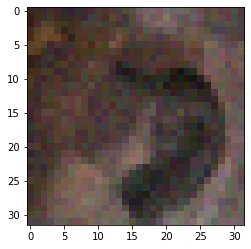

In [2]:
with np.load('prediction-challenge-02-data.npz') as fh:
    x_train = fh['x_train']
    y_train = fh['y_train']
    x_test = fh['x_test']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER (6000)
# 2/3. INDEX: PIXEL VALUE (32 x 32)
# 4. INDEX: COLOR CHANNELS (3)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)

# TEST DATA: INPUT (x) ONLY
print(x_test.shape, x_test.dtype)

plt.imshow(x_train[0])
print(y_train[0])

In [3]:
# TRAIN MODEL ON x_train, y_train

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
        inplace=True
    ),
])

for i in range(0,len(x_train)):
    transform(x_train[i,:,:,:])
    
train_x = torch.tensor(x_train)
train_x = train_x.permute(0,3,1,2)
train_y = torch.tensor(y_train)
dataset = TensorDataset(train_x,train_y)

train_set, val_set = torch.utils.data.random_split(dataset, [2400, 600])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
valloader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True)

dataiter = iter(trainloader)
images, labels = dataiter.next()

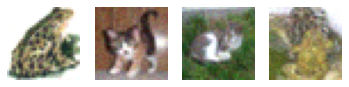

In [4]:
figure = plt.figure()
num_of_images = 4
for index in range(1, num_of_images + 1):
    plt.subplot(1, 4, index)
    plt.axis('off')
    plt.imshow(np.transpose(images[index].numpy().squeeze(), (1,2,0)))
    

In [5]:

class CNN(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 3)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [6]:
net = CNN()
criterion = nn.CrossEntropyLoss()
images, labels = next(iter(trainloader))
labels = labels.type(torch.LongTensor)

output = net(images)
loss = criterion(output, labels) #calculate the NLL loss

In [7]:
#print('Before backward pass: \n', net[0].weight.grad)
#loss.backward()
#print('After backward pass: \n', net[0].weight.grad)

In [11]:
learning_rate = 0.001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
time0 = time()
epochs = 50
for e in range(epochs):
    
    if e <= 10:
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    elif e > 10 and e <= 25:
        optimizer = optim.Adam(net.parameters(), lr=(learning_rate)/10)
    else:
        optimizer = optim.Adam(net.parameters(), lr=(learning_rate)/50) 
    
    running_loss = 0
    for images, labels in trainloader:    
        # Training pass
        optimizer.zero_grad()
        
        output = net(images)
        labels = labels.long()
        loss = criterion(output, labels)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    print("Epoch {} - Training loss: {}".format(e+1, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 1 - Training loss: 0.8861700745423635
Epoch 2 - Training loss: 0.8233812240759532
Epoch 3 - Training loss: 0.7862692948182424
Epoch 4 - Training loss: 0.7532547599077225
Epoch 5 - Training loss: 0.7250423586368561
Epoch 6 - Training loss: 0.714434361855189
Epoch 7 - Training loss: 0.6617553273836771
Epoch 8 - Training loss: 0.6275943299134572
Epoch 9 - Training loss: 0.5907248306274414
Epoch 10 - Training loss: 0.5715713808933894
Epoch 11 - Training loss: 0.5295665920774142
Epoch 12 - Training loss: 0.3880004042883714
Epoch 13 - Training loss: 0.34056470468640326
Epoch 14 - Training loss: 0.3098021938900153
Epoch 15 - Training loss: 0.297744159946839
Epoch 16 - Training loss: 0.26823878469566503
Epoch 17 - Training loss: 0.24840440083295107
Epoch 18 - Training loss: 0.25088567270586887
Epoch 19 - Training loss: 0.2245557703326146
Epoch 20 - Training loss: 0.2018773359184464
Epoch 21 - Training loss: 0.2037290803839763
Epoch 22 - Training loss: 0.18812028711040815
Epoch 23 - Train

In [58]:
#VALIDATION

correct_count, all_count = 0, 0
for images,labels in valloader:
    with torch.no_grad():
        output = net(images)

    pred_labels = torch.argmax(output, dim=1)
    correct = (pred_labels == labels).sum()
    correct_count += correct
    count = labels.shape[0]
    all_count += count
    
print("Number Of Images Tested =", all_count)
acc = float(correct_count/all_count)
print("\nModel Accuracy =", acc)

Number Of Images Tested = 600

Model Accuracy = 0.7016666531562805


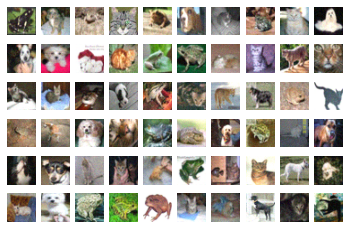

In [30]:
figure = plt.figure()
num_of_images = 60
for index in range(1,num_of_images+1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(x_test[index])

In [65]:
# PREDICT prediction FROM x_test
for i in range(0,len(x_test)):
    transform(x_test[i,:,:,:])

images_test = torch.tensor(x_test)
images_test = images_test.permute(0,3,1,2)

test_set = TensorDataset(images_test)
testloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False)

prediction = []
for images_test in testloader:
    with torch.no_grad():
        output = net(images_test[0])

    pred_labels = torch.argmax(output, dim=1).numpy()
    for i in range(0,len(pred_labels)):
        prediction.append(pred_labels[i])
    
prediction = np.array(prediction)

In [104]:
print(prediction[1:60])

[0 0 2 0 1 0 2 0 0 1 1 1 1 0 2 2 0 0 0 1 1 0 1 1 2 0 1 1 2 1 1 0 1 0 2 2 1
 2 0 1 1 0 0 1 0 2 1 0 1 2 0 1 2 2 0 0 1 0 0]


In [106]:
# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 300

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction.astype(int))

# MAKE SURE THAT THE FILE HAS THE CORRECT FORMAT
def validate_prediction_format():
    loaded = np.load('prediction.npy')
    assert loaded.shape == (300, )
    assert loaded.dtype == int
    assert (loaded <= 2).all()
    assert (loaded >= 0).all()
validate_prediction_format()